## Convolutional Neural Networks

## Dog Identification App 

---

In this notebook, an attempt is made towards developing a dog detection algorithm that could be used as part of a mobile or web app. The code will accept any user-supplied image as input, and if a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected it will provide an estimate of the dog breed that is most resembling. 

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Likewise, recall that labradors come in yellow, chocolate, and black.  Vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed. CNN seem to do a good job in accomplishing this complex task. It is not an easy task to train CNN's from scratch and is computationally very intensive. Techniques like 'transfer learning' and 'data augmentation' are used to improve the computational speed and accuracy of the algorithm. The algorithm is trained using a GPU on an Amazon EC2 instance. Also, a few ideas for improving the algorithm are mentioned towards the end.

### Overview

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): CNN to Classify Dog Breeds (using Transfer Learning)

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


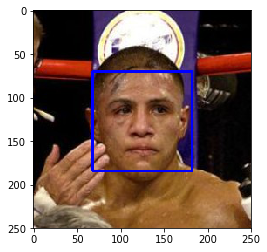

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [53]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

humans_as_humans = [face_detector(human_files_short[i]) for i in range(100) if face_detector(human_files_short[i])==True]
dogs_as_humans = [face_detector(dog_files_short[i]) for i in range(100) if face_detector(dog_files_short[i])==True]

percent_humans_as_humans = len(humans_as_humans)*100/100
percent_dogs_as_humans = len(dogs_as_humans)*100/100

print('%d percent of images in `human_files_short` have a detected human face'%len(humans_as_humans))
print('%d percent of images in `dog_files_short` have a detected human face'%len(dogs_as_humans))

98 percent of images in `human_files_short` have a detected human face
11 percent of images in `dog_files_short` have a detected human face


Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  Our algorithm falls short of this goal, but still gives acceptable performance.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which is also referred to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need to only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

The `dog_detector` function below returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

In [14]:
humans_as_dogs = [dog_detector(human_files_short[i]) for i in range(100) if dog_detector(human_files_short[i])==True]
dogs_as_dogs = [dog_detector(dog_files_short[i]) for i in range(100) if dog_detector(dog_files_short[i])==True]

percent_humans_as_dogs = len(humans_as_dogs)*100/100
percent_dogs_as_dogs = len(dogs_as_dogs)*100/100

print('%d percent of images in `human_files_short` have a detected dog face'%len(humans_as_dogs))
print('%d percent of images in `dog_files_short` have a detected dog face'%len(dogs_as_dogs))

2 percent of images in `human_files_short` have a detected dog face
100 percent of images in `dog_files_short` have a detected dog face


---
<a id='step3'></a>
## Step 3: CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we write a CNN that classifies dog breeds. 

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.   

### Pre-process the Data

Rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 139.10it/s]


### (IMPLEMENTATION) Model Architecture
          
Final CNN architecture that is implemented in the following code cell is arrived at by experimenting with different architectures in the following manner. 

-  ** First model: ** 2 alternate convolutional2D and MaxPooling2D layers  with kernel_size=2 and activation='relu'. Then using flatten() generates a large number of parameters to be trained which will increase the n_epochs. So used a GloablAveragePooling2D layer and straight away final Dense layer with 'softmax' activation. An accuracy of 1.56% is achieved in 5 epochs. For 10 epochs, accuracy was 3%

-  ** Second model: ** Keeping the same architecture as above, a dense layer was added after the GloabalAveragePooling layer with 400 nodes and activation='relu'; this was done with the idea of improving the accuracy  at a faster rate. However this increases the number of parameters more than 14 times. This increased the training time (each epoch took ~ 20sec), but the test accuracy after 5 epochs is still 1.56%

-  ** Third model: ** Thinking that the model might be over fitting with the additional dense layer, a Dropout(0.3) was added after the first dense layer. For the same training time as model-2, test accuracy increased considerably to 2.3% after 5 epochs and 4.1% after 10 epochs.

-  ** Fourth model: ** To improve the accuracy of dog detection, it is better to increase the depth of convolutional layers. So, I added additional convolutional layer (64 filters and kernal_size=2) and a MaxPooling layer to the model above. This increases the training time to 22 sec/epoch and test accuracy to 2.63% after 5 epochs and 5% after 10 epochs.

-  ** Fifth model: ** Adding another set of convolutional (filters=128) and maxpooling layer increased the training time to 27 s/epoch and test accuracy to 4.31% after 5 epochs.

-  ** Sixth model: ** Although model-5 worked well, reduced training time would be better. So I ran another model by removing the penultimate Dense layer. i.e there are 4 sets of alternalte convolutional and maxpooling layers, a globalpoolingaverage and a final dense layer. This reduced the training time to 23 s/epoch and test accuracy is 4.1% after 5 epochs. So this model looks good with respect to both training time and test accuracy. Hence, this model was used to run more epochs. After 50 epochs, the accuracy is 17.5%.

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding ='same', activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2, padding ='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128,kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       32896     
__________

### Compile the Model

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [75]:
from keras.callbacks import ModelCheckpoint  

epochs = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 24s - loss: 4.8818 - acc: 0.0105 - val_loss: 4.8514 - val_acc: 0.0168
Epoch 2/50
6680/6680 [==============================] - 23s - loss: 4.8190 - acc: 0.0168 - val_loss: 4.7938 - val_acc: 0.0192
Epoch 3/50
6680/6680 [==============================] - 23s - loss: 4.7671 - acc: 0.0199 - val_loss: 4.7876 - val_acc: 0.0204
Epoch 4/50
6680/6680 [==============================] - 23s - loss: 4.7154 - acc: 0.0228 - val_loss: 4.7070 - val_acc: 0.0311
Epoch 5/50
6680/6680 [==============================] - 23s - loss: 4.6579 - acc: 0.0307 - val_loss: 4.6613 - val_acc: 0.0383
Epoch 6/50
6680/6680 [==============================] - 23s - loss: 4.5882 - acc: 0.0380 - val_loss: 4.6140 - val_acc: 0.0383
Epoch 7/50
6680/6680 [==============================] - 23s - loss: 4.5091 - acc: 0.0443 - val_loss: 4.5678 - val_acc: 0.0359
Epoch 8/50
6680/6680 [==============================] - 23s - loss: 4.4

### Load the Model with the Best Validation Loss

In [76]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [77]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 17.4641%


The test accuracy is not very high, still much better than the random guess. It is evident from the above process, how difficult it is to train a CNN from scratch. To reduce training time without sacrificing accuracy, it is best to train a CNN using transfer learning.  In the next part of this notebook, we implemented transfer learning to train CNN.

---
<a id='step4'></a>
## Step 4: CNN to Classify Dog Breeds

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to this model.  A global average pooling layer and a fully connected layer are added, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.1853 - acc: 0.1275 - val_loss: 10.8483 - val_acc: 0.2108
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.0892 - acc: 0.2897 - val_loss: 9.9499 - val_acc: 0.2946
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.5591 - acc: 0.3427 - val_loss: 9.7213 - val_acc: 0.3269
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.2469 - acc: 0.3817 - val_loss: 9.6332 - val_acc: 0.3269
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.0949 - acc: 0.4010 - val_loss: 9.5170 - val_acc: 0.3401
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.9964 - acc: 0.4177 - val_loss: 9.4711 - val_acc: 0.3437
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.8075 - acc: 0.4240 - val_loss: 9.2189 - val_acc: 0.3533
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.5496 -

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

In [23]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.8995%


### Predict Dog Breed with the Model

In [21]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: CNN to Classify Dog Breeds (using Transfer Learning)

In Step 4, bottleneck features from VGG-16 model was used to create a CNN. In this step, the bottleneck features from - [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz), a different pre-trained model are used.  

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

-  ** Model 1: ** Started with a simple model of first using a GlobalAveragePooling and then a fully connected dense layer of nodes=n_categories. It gives the test_accuracy of 81%

-  ** Model 2: ** Added a fully connected dense layer with 400 nodes and a dropout(0.3) layer as a penultimate layer. This did not improve the model (it increased training time and also no improvement after 3 epochs; test accuracy reduced to 77%). I am going to use Model-1 as it is giving good accuracy.

In [25]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133,activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [26]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6367 - acc: 0.5976 - val_loss: 0.8340 - val_acc: 0.7413
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4453 - acc: 0.8642 - val_loss: 0.7147 - val_acc: 0.7760
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.2690 - acc: 0.9147 - val_loss: 0.6622 - val_acc: 0.7892
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.1785 - acc: 0.9445 - val_loss: 0.6348 - val_acc: 0.8108
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1239 - acc: 0.9626 - val_loss: 0.6808 - val_acc: 0.7988
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0844 - acc: 0.9738 - val_loss: 0.7166 - val_acc: 0.8048
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0635 - acc: 0.9807 - val_loss: 0.6899 - val_acc: 0.8108
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0461 - ac

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [28]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

In [29]:
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.6986%


### (IMPLEMENTATION) Predict Dog Breed with the Model

The following function takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

In [30]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Final Algorithm

The following algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, it returns the predicted breed.
- if a __human__ is detected in the image, it returns the resembling dog breed.
- if __neither__ is detected in the image, it provides an output that indicates an error.

In [81]:
def image_recognition(img_path):
    if face_detector(img_path) == True:
        print("Hello Human!")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        return Resnet50_predict_breed(img_path)
    elif dog_detector(img_path) == True:
        print("This is a dog!")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        return Resnet50_predict_breed(img_path)
    else:
        print("This is neither a dog nor human!")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()

### (IMPLEMENTATION) Testing the Algorithm on Sample Images!  

This is neither a dog nor human!


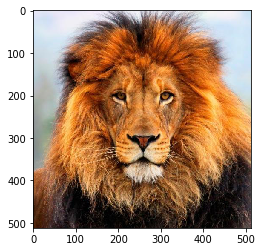

You look like  None


In [82]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
img_path = 'test_images/lion.jpg'
dog_breed_predict = image_recognition(img_path)
print('You look like ', dog_breed_predict)

Hello Human!


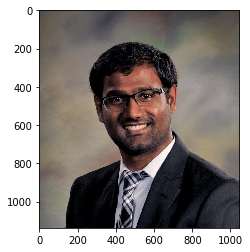

You look like  Lowchen


In [84]:
img_path = 'test_images/yathish_2.jpg'
dog_breed_predict = image_recognition(img_path)
print('You look like ', dog_breed_predict)

This is neither a dog nor human!


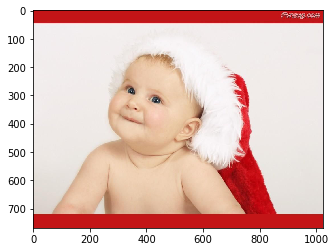

You look like  None


In [88]:
img_path = 'test_images/kid.jpg'
dog_breed_predict = image_recognition(img_path)
print('You look like ', dog_breed_predict)

This is neither a dog nor human!


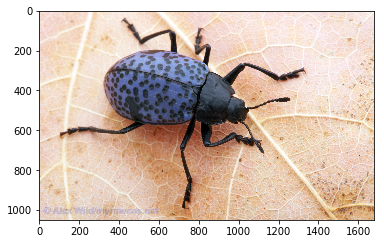

You look like  None


In [89]:
img_path = 'test_images/insect.jpg'
dog_breed_predict = image_recognition(img_path)
print('You look like ', dog_breed_predict)

This is neither a dog nor human!


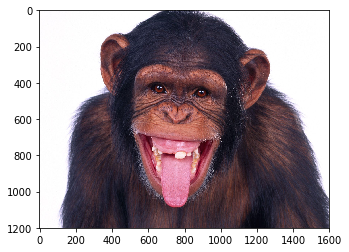

You look like  None


In [91]:
img_path = 'test_images/monkey.jpg'
dog_breed_predict = image_recognition(img_path)
print('You look like ', dog_breed_predict)

This is a dog!


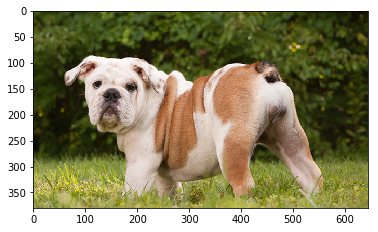

You look like  Bulldog


In [92]:
img_path = 'test_images/bulldog.jpg'
dog_breed_predict = image_recognition(img_path)
print('You look like ', dog_breed_predict)

This is a dog!


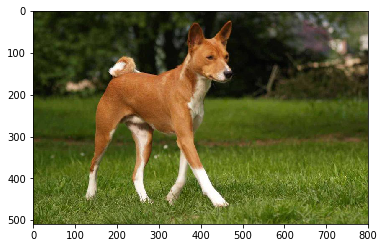

You look like  Basenji


In [93]:
img_path = 'test_images/basenji.jpg'
dog_breed_predict = image_recognition(img_path)
print('You look like ', dog_breed_predict)

This is a dog!


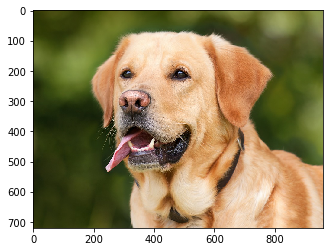

You look like  Golden_retriever


In [94]:
img_path = 'test_images/labrador.jpg'
dog_breed_predict = image_recognition(img_path)
print('You look like ', dog_breed_predict)

-  Firstly, all images that are neither dogs nor humans are identified correctly except for the kid.
-  Two of the dog breeds basenji & bulldog are predicted correctly. The other one which is a labrador is not predicted correctly (some of the golden_retriever images look similar though and hence the wrong prediction)
-  Results for lion is particularly good because i was expecting it might be recognized as a dog. 
-  The algorithm can be improved by using more layers in the neural network (probably adding a convolution layer after the transfer learning parameters) and expanding the training set to more dog breeds will be helpful.  
-  Another way to improve data is to use image augmentation.